# KALMAN FILTER IN A SIMPLE ROBOTICS PROBLEM

## Problem Setup

Imagine a robot that can only move at right angles (like a knight in chess). Its state constitutes only its (x,y) cooridines. When you ask it to move, it first travels along the x axis with a predefined velocity for time dt. Then it travels along the y axis with a pre-defined velocity along y axis for the same dt. Hence, with 1 'move' action it traverses its domain for time 2dt and is displaced along both directions

The robot tries to keep track of its state by using kinematics principles: 
    
$$ x_f = x_o + vdt $$
(this is called dead reckoning)

However, the floor is slippery, so the distance it covers along each dimension is stochastic. If we keep asking the robot to move, then errors in the robot's estimate of its state could accumulate, making it more and more uncertain about its state (i.e. increasing variance in state estimate). Also note that while moving in the x direction, the slipping doesnt effect the robot's y coordiante and vice versa. 

So, we equip the robot with 2 proximity sensors. Each sensor is able to measure how far the robot is from one of the coordinate axes. Sensor 1 is able to measure the distance from Y axis. Sensor 2 is able to measure the distance form X axis. However, the robot can only use one sensor at a time.

Now, the robot can use these observations and assimilate them with its motion model, so as to improve its state estimate. It is also programmed with an implantation of the Kalman filter. Moreover, we have provided it with parameters of model noise and sensor noise.

In essence, our robot is capable of following two commands: move and sense.

When you ask it to move, it will implement the prediction step using its motion model.

When you ask it to sense, it will make an observation implement the correction step

In the code:

Kalman.predict() performs the ‘move’ action.

Kalman.correct() performs the ‘sense’ action.


--------------------

## Implementation

### Note: Please go through all the comments marked inside tripple quotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

In [2]:
"""
Numerical values for all relant data and matrices.
EXPERIMENT BY CHANGING THESE VALUES. ESPECIALLY VARAINCE TERMS.
"""

#initial mean and covariance of state
mean_0 = np.array([0,0])
covar_0 = 0.4*np.array([[1,0],[0,1]])

#variance terms from model noise and obs noise
sigma_xx = 0.5
sigma_yy = 0.25
sigma_obs_1 = 0.5
sigma_obs_2 = 0.5

#velocity of the robot
vx = 4
vy = 6


A = np.array([[1,0],[0,1]])                 #state transition matrix
Q = np.array([[sigma_xx,0],[0,sigma_yy]])   #model noise covariance matrix

H1 = np.array([[1, 0]])     #Observation matrix for sensor 1 or sensor x
H2 = np.array([[0,1]])      #Observation matrix for sensor 2 or sensor y
R1 = sigma_obs_1            #Obs noise covariance matrix for sensor 1 or sensor x
R2 = sigma_obs_2            #Obs noise covariance matrix for sensor 2 or sensor y

C = np.array([vx, vy])      #velocity vector


"""
Visualisation parameters: only effect how the plot looks. Doesn't effect prediction/correction process
"""
#plor limits
xlim = [-2,20]
ylim = [-2,20]

#plot ellipse upto n_sigma std deviztions in both directions 
n_sigma = 3

In [3]:
"""
X_{k+1} = AX{k} + C + eps, eps~N(0,Q)
Z_{k} = HX{k} + del, del ~ N(0,R)
C = [vx, vy].T

sensor1 ~ sensor ='x' ~ measures noisy x coordinate
sensor2 ~ sensor ='y' ~ measures noisy y coordinate

This cell contains the implementation of the kalman filter and plotting function.
Be careful while making changes (if any) here.

"""


class system:

    def __init__(self, mean_0, covar_0, A, C, H1, H2, Q, R1, R2):
        self.A = A
        self.H1 = H1
        self.H2 = H2
        self.C = C
        self.Q = Q
        self.R1 = R1
        self.R2 = R2
        self.mean = mean_0
        self.covar = covar_0
        self.uncertainty_history= [(mean_0, covar_0)]
        
        #true state info
        self.true_state = np.random.multivariate_normal(mean_0, covar_0)
        self.state_history=[self.true_state]


    def predict(self, dt = 1):
        """
        makes robot move for timestep dt and then performs prediction step of KF
        """
        
        #prediction
        pred_mean = np.matmul(self.A, self.mean) + self.C*dt
        pred_covar = np.matmul(np.matmul(self.A.T, self.covar), self.A) + (dt**2)*self.Q
        self.mean = pred_mean
        self.covar = pred_covar
        
        self.uncertainty_history.append((self.mean, self.covar))
        
        #simulating true state evolution
        eps = np.random.multivariate_normal(np.zeros(self.mean.shape), self.Q)
        self.true_state = np.matmul(self.A, self.true_state) + self.C*dt + eps
        self.state_history.append(self.true_state)
        
        self.visualise(fig_title = 'Predict after agent moves')
        return pred_mean, pred_covar
    
    
    def sample_obs(self, sensor = 'x'):
        """
        makes a noisy observation of one of its coordites depending on which sensor was used
        
        TO DO:
        change the line below for general n-dim version
        """
        if sensor == 'x':
            H = self.H1
            R = self.R1
        elif sensor =='y':
            H = self.H2
            R = self.R2
            
        delta = np.random.normal(0, R)
        z = np.matmul(H,self.true_state) + delta
        return z

    
    def correct(self, sensor = 'x'):
        """
        makes the robot use specified sensor and then perform the correction step of KF
        """
        
        mu =self.mean
        sigma = self.covar
        z = self.sample_obs(sensor = sensor)
        
        if sensor == 'x':
            H = self.H1
            R = self.R1
        elif sensor == 'y':
            H = self.H2
            R = self.R2
             
        innovation = z - np.matmul(H, mu)
        S = np.matmul(np.matmul(H, sigma), H.T) + R
        S_inv = np.linalg.inv(S)
        K = np.matmul(np.matmul(sigma,H.T), S_inv)
        
        cor_mean = mu + np.matmul(K, innovation)
        temp = np.matmul(K,H)
        I = np.eye(temp.shape[0], temp.shape[1])
        cor_covar = np.matmul((I - np.matmul(K,H)), sigma)
        
        self.mean = cor_mean
        self.covar = cor_covar
        
        self.uncertainty_history.append((cor_mean, cor_covar))
        self.state_history.append(self.true_state) #this line is just for plotting conve
        
        self.visualise(fig_title = 'Correction with sensor ' + sensor)
        return cor_mean, cor_covar
    
    
    
    def visualise(self, fig_title=''):
        
        """
        plotting function to help visualise uncertainty evolution
        """
        
        def ellipse(xx, yy):
            return (1/n_sigma**2) * ( ((xx-mu[0])/sigma[0,0])**2 + ((yy-mu[1])/sigma[1,1])**2 )
        
        f = np.vectorize(ellipse) 
        dist = 10
        plt.figure(figsize= (10,10))
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xlabel('X')
        plt.ylabel('y')
        
        fig_name = 'Uncertainty evolution uptil action ' + str(len(self.uncertainty_history) - 1) + '\n' + fig_title
        
        plt.title(fig_name, fontsize = 'xx-large')
        plt.axhline(y=0, xmin = xlim[0], xmax = xlim[1])
        plt.axvline(x=0, ymin = ylim[0], ymax = ylim[1])
        
        num_mesh_pts =50
        for i in range(len(self.uncertainty_history)):
            mu, sigma = self.uncertainty_history[i]
            x = np.linspace(mu[0] - dist, mu[0] + dist, num_mesh_pts)
            y = np.linspace(mu[1] - dist, mu[1] + dist, num_mesh_pts)
            x, y = np.meshgrid(x,y)
            plt.contourf(x,y,f(x, y), levels = [0,1], alpha = 0.6**(len(self.uncertainty_history)-i-1))
       
        for i in range(len(self.state_history)):
            a, b = self.state_history[i]
            plt.scatter(a, b, marker = '*', zorder =100, color = 'r')
            
        plt.scatter(float('inf'), float('inf'),marker = '*', zorder =100, color = 'r', label = 'True State Trajectory')
        plt.legend()
        plt.show()
                  
                  

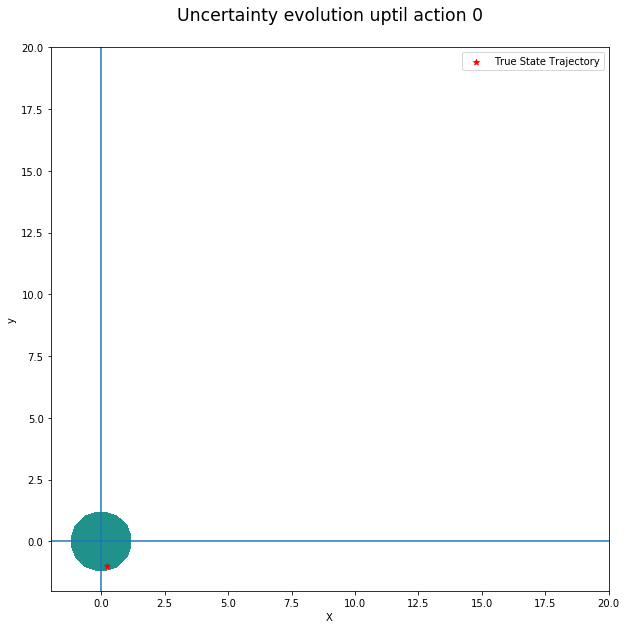

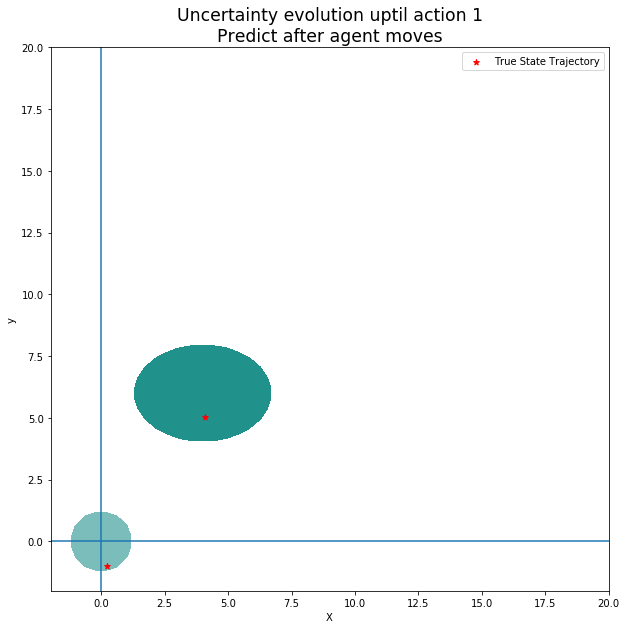

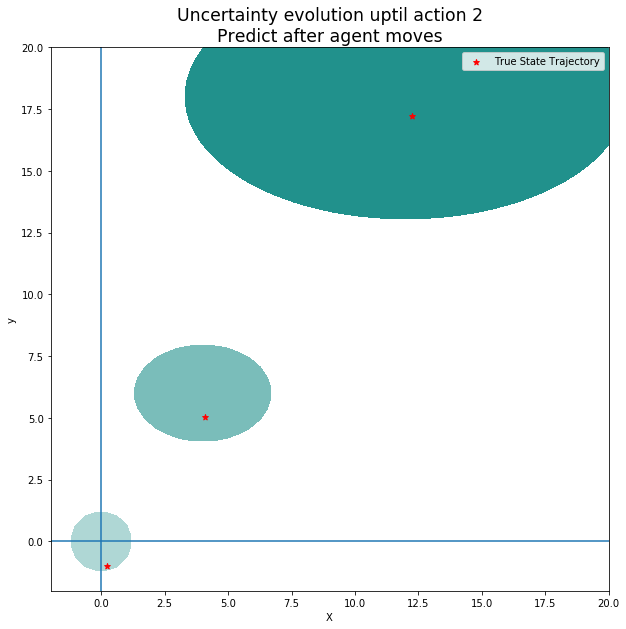

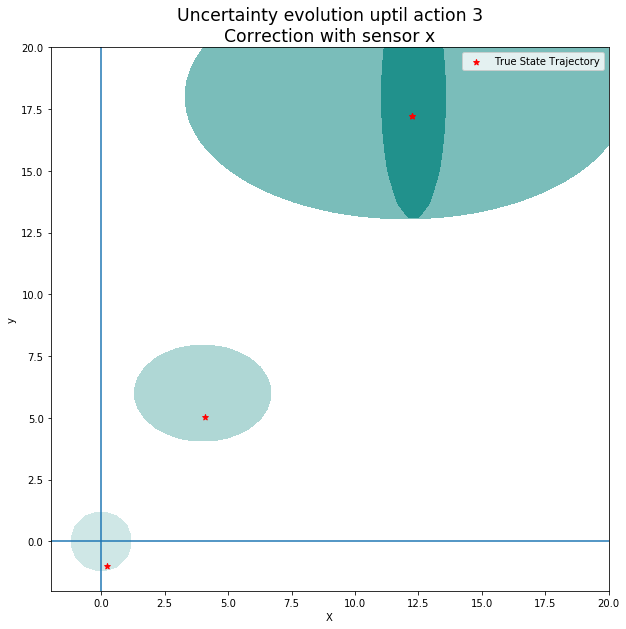

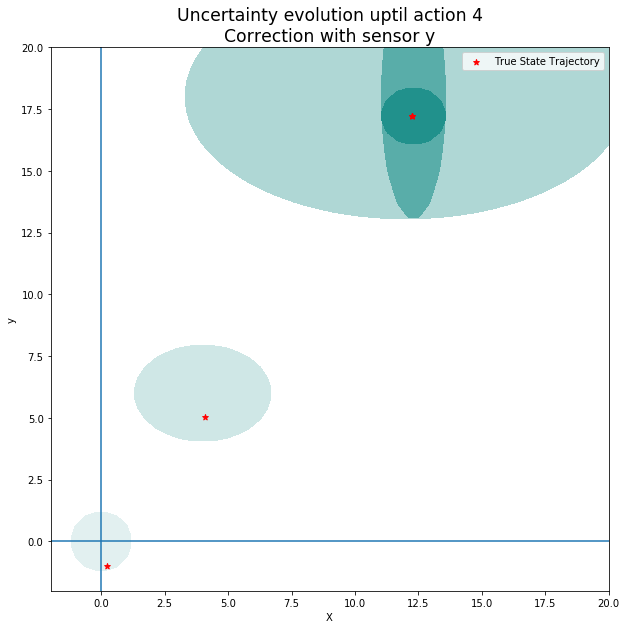

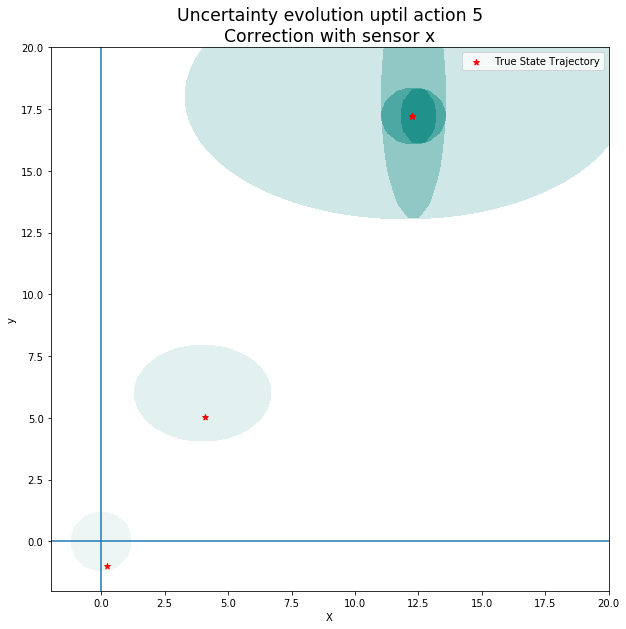

(array([12.5044656 , 17.21365156]), array([[0.23015873, 0.        ],
        [0.        , 0.38372093]]))

In [6]:
"""
THIS CELL IS FOR YOU TO EXPERIMENT AND VISUALISE WHATS HAPPENING.

MAKE CHANGES IN PART 2. YOU CAN TRY OUT DIFFERENCT SEQUENCES OF PREDICT AND CORRECT WITH DIFFERENT TIMESTEPS 
ANS SENSOR CHOICES.

ALSO TRY CHANGING NUMERICAL VALUES IN CELL 2

Note:
1. Each call to the prediction(dt = DT) function is equaivalent to telling the robot to move for time DT and 
   then predicting its mean and covariance as per the transition model
2. Each call to correction(sensor = 'x' or 'y') function, makes the robot first sample an observation from the sensor 
   mentioned in the argument, and then perform the correction step, hence reducing the uncertainty.
3. Each call to the visualse() fuction helps you visualise the uncertainty evolution uptil that point of time.
   The darker the ellipse, the more recently it was generated,

"""
#PART 1
#initilise the robot system with the above specified matrices
kalman = system(mean_0, covar_0, A, C, H1, H2, Q, R1, R2)
kalman.visualise()

#PART 2
#WRITE YOUR PREDICT/ CORRECT ACTION SEQUENCE HERE. EXAMPLE GIVEN BELOW.
kalman.predict(dt = 1)
kalman.predict(dt = 2)
kalman.correct(sensor = 'x')
kalman.correct(sensor = 'y')
kalman.correct(sensor = 'x')

------------------

## QUESTIONS TO THINK ABOUT:


1. If I keep using the correct step, would the uncertainty in state tend to vanish?


2. What happens if the variance of observation noise is much larger than compared to those of model noise ?